In [109]:
from jupyterthemes import jtplot
jtplot.style()

# Titanic 
Here is a solution for titanic disaster. 

Data set is [here](https://www.kaggle.com/c/titanic)

## Importing Data 


In [110]:
import pandas as pd
import numpy as np
import os
TRAIN_PATH = 'datasets/titanic'
TEST_PATH = 'datasets/titanic'
def load_titanic_data(TRAIN_PATH, TEST_PATH):
    train_csv = os.path.join(TRAIN_PATH, 'train.csv')
    test_csv = os.path.join(TEST_PATH, 'test.csv')
    return pd.read_csv(train_csv), pd.read_csv(test_csv)

In [111]:
train_set, test_set = load_titanic_data(TRAIN_PATH, TEST_PATH)

### Shuffling 

In [112]:
train_set = train_set.sample(frac=1)

## Let see our beautiful data :D

In [113]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


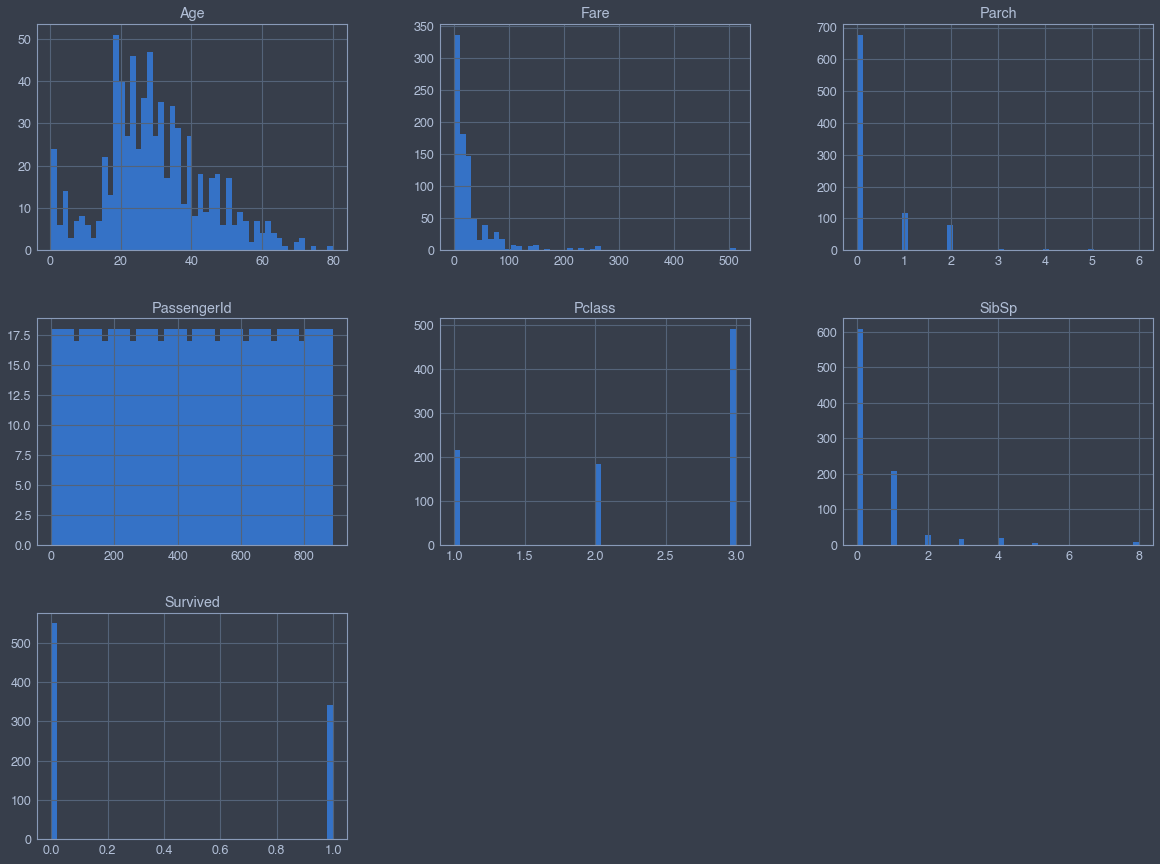

In [114]:
import matplotlib.pyplot as plt
train_set.hist(figsize=(20, 15), bins=50)
plt.show()

## Prune Our Data Set

In [115]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 707 to 819
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


As you see some data have not value. For example Cabin is have a lots on null values

In [116]:
distinct_cabin_value = len(np.unique(train_set.Cabin.values.astype(np.str)))
distinct_cabin_value

148

There is 148 distinct value from 204 total non-null value. So this data probably can not Impute with mean and others. We **drop** it.

Other values can be Impute with Imputer.




In [117]:
distinct_ticket_value = len(np.unique(train_set.Ticket.values.astype(np.str)))
distinct_ticket_value

681

Ticket number is also an attribute which does not impact on our prediction because of number of their distinct values.

Also there is some unique values like **PassengerId** or **Name** which 

In [118]:
from sklearn.base import BaseEstimator, TransformerMixin
class DeleteExtraAttr(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(["Cabin", "Ticket", "PassengerId"], axis=1)

In [119]:
delete_attr = DeleteExtraAttr()
train_set_deleted = delete_attr.transform(train_set)
test_set_deleted = delete_attr.transform(test_set)
train_set_deleted.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
707,1,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,26.2875,S
807,0,3,"Pettersson, Miss. Ellen Natalia",female,18.0,0,0,7.7750,S
565,0,3,"Davies, Mr. Alfred J",male,24.0,2,0,24.1500,S
228,0,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,13.0000,S
195,1,1,"Lurette, Miss. Elise",female,58.0,0,0,146.5208,C


Also we can just get `Mr`, `Ms`, ... from name

In [120]:
train_set_pruned = train_set_deleted.copy()
test_set_pruned = test_set_deleted.copy()
train_set_pruned['Name'] = train_set_pruned['Name'].apply(lambda l: l.split(',')[1].split('.')[0][1:])
test_set_pruned['Name'] = test_set_pruned['Name'].apply(lambda l: l.split(',')[1].split('.')[0][1:])
train_set_pruned.head()
pd.crosstab(train_set_pruned['Name'], [train_set_pruned['Sex'] ,train_set_pruned['Survived']])

Sex          female      male    
Survived          0    1    0   1
Name                             
Capt              0    0    1   0
Col               0    0    1   1
Don               0    0    1   0
Dr                0    1    4   2
Jonkheer          0    0    1   0
Lady              0    1    0   0
Major             0    0    1   1
Master            0    0   17  23
Miss             55  127    0   0
Mlle              0    2    0   0
Mme               0    1    0   0
Mr                0    0  436  81
Mrs              26   99    0   0
Ms                0    1    0   0
Rev               0    0    6   0
Sir               0    0    0   1
the Countess      0    1    0   0

In [121]:
class SmoothOutName(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dataset = X.copy()
        dataset['Name'] = dataset['Name'].replace(['the Countess', 'Sir', 'Rev', 'Major', 'Lady',
                                                  'Jonkheer', 'Dr', 'Don', 'Col', 'Capt'], 'Rare')
        dataset['Name'] = dataset['Name'].replace(['Mme', 'Mrs', 'Ms', 'Mlle', 'Miss'], 'Miss')
        return dataset

In [122]:
train_set_pruned = SmoothOutName().transform(train_set_pruned)
test_set_pruned = SmoothOutName().transform(test_set_pruned)

In [123]:
pd.crosstab(train_set_pruned['Name'], [train_set_pruned['Sex'] ,train_set_pruned['Survived']])

Sex      female      male    
Survived      0    1    0   1
Name                         
Master        0    0   17  23
Miss         81  230    0   0
Mr            0    0  436  81
Rare          0    3   15   5





## Ploting our remained attributes to see what we have

### Correlations

In [124]:
corr_matrix = train_set.corr()
corr_matrix['Survived'].sort_values()

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

In [125]:
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

### Visualization

In [126]:
train_set_pruned.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
707,1,1,Mr,male,42.0,0,0,26.2875,S
807,0,3,Miss,female,18.0,0,0,7.7750,S
565,0,3,Mr,male,24.0,2,0,24.1500,S
228,0,2,Mr,male,18.0,0,0,13.0000,S
195,1,1,Miss,female,58.0,0,0,146.5208,C


In [127]:
is_male = train_set_pruned['Sex'] == 'male'
survived_or_not = train_set_pruned['Survived'] == 1
male_survived = train_set_pruned[is_male & survived_or_not]
female_survived = train_set_pruned[~is_male & survived_or_not]
male_not_survived = train_set_pruned[is_male & ~survived_or_not]
female_not_survived = train_set_pruned[~is_male & ~survived_or_not]

(81, 233)

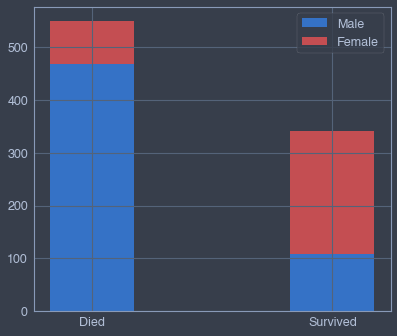

In [128]:
male_aliveness = (len(male_not_survived), len(male_survived))
female_aliveness = (len(female_not_survived), len(female_survived))
p1 = plt.bar(('Died', 'Survived'), male_aliveness , 0.35, color="b")
p2 = plt.bar(('Died', 'Survived'), female_aliveness , 0.35, color="r", bottom=male_aliveness)
plt.legend((p1[0], p2[0]), ('Male', 'Female'))
female_aliveness

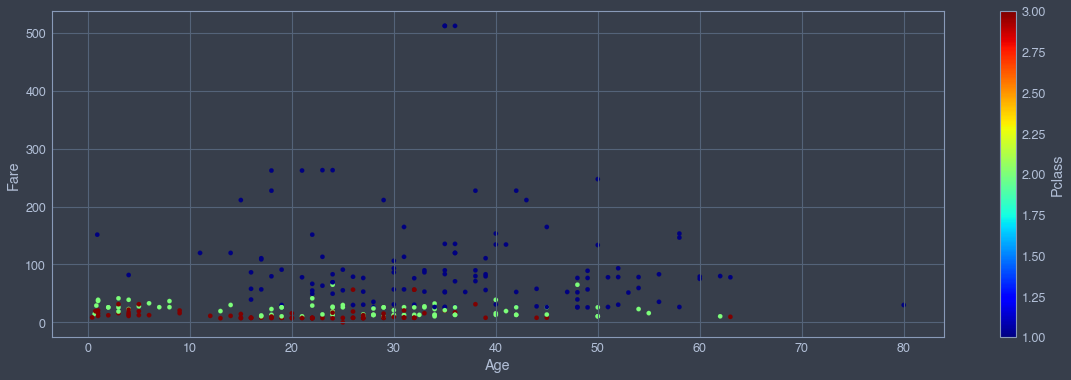

In [129]:
titanic_survived = train_set_pruned[train_set_pruned['Survived'] == 1]
fig,ax1=plt.subplots()
titanic_survived.plot(kind="scatter", x="Age", y="Fare",
                      c="Pclass", cmap=plt.get_cmap("jet"), figsize=(20, 6), ax=ax1)

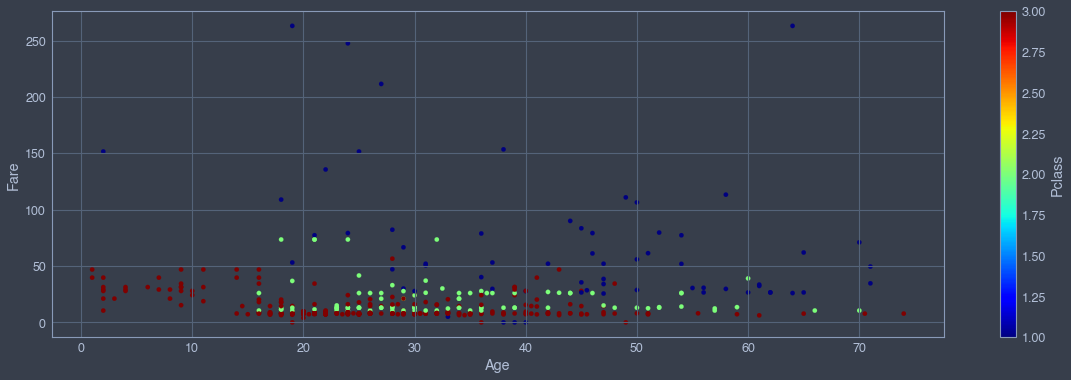

In [130]:
titanic_died = train_set_pruned[train_set_pruned['Survived'] == 0]
fig,ax1=plt.subplots()
titanic_died.plot(kind="scatter", x="Age", y="Fare",
                      c="Pclass", cmap=plt.get_cmap("jet"), figsize=(20, 6), ax=ax1)

Know we can delete some datas with some threshold. Data with Age > 70 and Fare > 300 is useless.


In [131]:
median = train_set_pruned['Age'].median()
train_set_pruned['Age'] = train_set_pruned['Age'].fillna(median)
test_set_pruned['Age'] = test_set_pruned['Age'].fillna(median)
age_cond = train_set_pruned['Age'] < 66 
fare_cond = train_set_pruned['Fare'] < 300
train_set_pruned[ age_cond & fare_cond ].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
707,1,1,Mr,male,42.0,0,0,26.2875,S
807,0,3,Miss,female,18.0,0,0,7.7750,S
565,0,3,Mr,male,24.0,2,0,24.1500,S
228,0,2,Mr,male,18.0,0,0,13.0000,S
195,1,1,Miss,female,58.0,0,0,146.5208,C


We can classify our age in some groups


[0, 17],
[17, 37],
[37, 49],
[49, 66],

In [132]:
class AgeGrouper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dataset = X.copy()
        dataset.loc[ dataset['Age'] <= 16, 'AgeGP'] = 0
        dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 37), 'AgeGP'] = 1
        dataset.loc[(dataset['Age'] > 37) & (dataset['Age'] <= 49), 'AgeGP'] = 2
        dataset.loc[(dataset['Age'] > 49) & (dataset['Age'] <= 66), 'AgeGP'] = 3
        dataset.loc[ dataset['Age'] > 66, 'Age'] = 4
        dataset['Age*Class'] = dataset['AgeGP'] * dataset['Pclass']
        return dataset
train_set_pruned = AgeGrouper().transform(train_set_pruned)
test_set_pruned = AgeGrouper().transform(test_set_pruned)

Family attribute say that person has family or not. 

In [133]:
class IsAloneDecider(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dataset = X.copy()
        dataset['Family'] = dataset['SibSp'] + dataset['Parch']
        dataset['Family'] = (dataset['Family'] > 0).astype(np.int)
        return dataset
train_set_pruned = IsAloneDecider().transform(train_set_pruned)
test_set_pruned = IsAloneDecider().transform(test_set_pruned)

#### Some Tips
* As you see pclass doesn't mean less fare! 
* There is more 1st class in survived and more 3d class in died people
* Childrens of second and first class not died.

## Clean Rest Of Data

We remove some column and here we just remove nulls with median strategy.


In [134]:
train_set_pruned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 707 to 819
Data columns (total 12 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Name         891 non-null object
Sex          891 non-null object
Age          891 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null float64
Embarked     889 non-null object
AgeGP        884 non-null float64
Age*Class    884 non-null float64
Family       891 non-null int64
dtypes: float64(4), int64(5), object(3)
memory usage: 90.5+ KB


Because we have a lots of data in age and it can computed with mean

### Make some transformers for our pipline
Label Binarizer and Label Encoder should reimplement for pipelines. also a DataFrameSelector should be implemented to every pipeline. 

In [135]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly,self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

class LabelEncoderPiplineFriendly(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
#         super(LabelEncoderPiplineFriendly,self).fit(X)
        return self
    def transform(self, X, y=None):
#         return super(LabelEncoderPiplineFriendly, self).transform(X).reshape(-1, 1)
        return X.apply(LabelEncoder().fit_transform)
    def fit_transform(self, X, y=None):
        r = self.transform(X, y)
        return r

In [136]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrs):
        self.attrs = attrs
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attrs]
    

In [137]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder

num_attrs = ['Pclass', 'Age', 'Fare', 'Family', 'Age*Class']
label_attrs = ['Embarked']
sex_attrs = ['Sex', 'Name']
all_atrrs = num_attrs + label_attrs + ['Embarked2', 'Embarked3'] + sex_attrs

numbers_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attrs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

labels_pipeline = Pipeline([
    ('selector', DataFrameSelector(label_attrs)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('one_hot', LabelBinarizerPipelineFriendly()),
])

sex_pipeline = Pipeline([
    ('selector', DataFrameSelector(sex_attrs)),
    ('encoder',LabelEncoderPiplineFriendly()),
    ('std_scaler', StandardScaler()),
])

full_pipeline = FeatureUnion([
    ('num_pipeline', numbers_pipeline),
    ('label_pipeline', labels_pipeline),
    ('sex_pipeline', sex_pipeline),
])

labels = train_set_pruned['Survived'].values
clean_data = full_pipeline.fit_transform(train_set_pruned)
clean_data_df = pd.DataFrame(clean_data, columns=all_atrrs)

In [138]:
clean_data_df.head()

,Pclass,Age,Fare,Family,Age*Class,Embarked,Embarked2,Embarked3,Sex,Name
0,-1.566107,1.043325,-0.119131,-0.811922,-0.322189,0.0,0.0,1.0,0.737695,0.666638
1,0.827377,-0.857164,-0.491874,-0.811922,0.311521,0.0,0.0,1.0,-1.355574,-0.947423
2,0.827377,-0.382041,-0.162169,1.231645,0.311521,0.0,0.0,1.0,0.737695,0.666638
3,-0.369365,-0.857164,-0.386671,-0.811922,-0.322189,0.0,0.0,1.0,0.737695,0.666638
4,-1.566107,2.310318,2.301729,-0.811922,0.311521,1.0,0.0,0.0,-1.355574,-0.947423


In [139]:
some_person = clean_data[10]
some_person_label = labels[10]

## Do The Magic (Classification)

### SGD Classification

In [140]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
sgd_model = SGDClassifier()
sgd_model.fit(clean_data, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [141]:
sgd_model.predict([some_person])

array([1])

### Check SGD Scores

In [142]:
from sklearn.model_selection import cross_val_score, cross_val_predict
sgd_scores = cross_val_score(sgd_model, clean_data, labels, cv=3, scoring="accuracy")
sgd_scores

array([0.79461279, 0.74410774, 0.77441077])

In [143]:
from sklearn.metrics import f1_score
sgd_pred = cross_val_predict(sgd_model, clean_data, labels, cv=3)
f1_score(labels, sgd_pred)

0.5970149253731343

### Random Forest Calssification

In [144]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(clean_data, labels)
rf_model.predict([some_person])

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([1])

### Check Random Forest Scores


In [145]:
rf_scores = cross_val_score(rf_model, clean_data, labels, cv=3, scoring="accuracy")
rf_scores

array([0.83164983, 0.7979798 , 0.82828283])

In [146]:
rf_pred = cross_val_predict(rf_model, clean_data, labels, cv=3)
f1_score(labels, rf_pred)

0.7565084226646248

### RBF Classification

In [147]:
from sklearn.svm import SVC
rbf_model = SVC(kernel="rbf", gamma="scale")
rbf_model.fit(clean_data, labels)
rbf_model.predict([some_person])

array([0])

### Check RBF Scores

In [148]:
rbf_scores = cross_val_score(rbf_model, clean_data, labels, cv=3, scoring="accuracy")
rbf_scores

array([0.83501684, 0.78451178, 0.84175084])

In [149]:
rbf_pred = cross_val_predict(rbf_model, clean_data, labels, cv=3)
f1_score(labels, rbf_pred)

0.738562091503268

### Gaussian Classification

In [150]:
from sklearn.gaussian_process import GaussianProcessClassifier
gs_model = GaussianProcessClassifier()
gs_model.fit(clean_data, labels)
gs_model.predict([some_person])

array([0])

In [151]:
gs_scores = cross_val_score(gs_model, clean_data, labels, cv=3, scoring="accuracy")
gs_scores

array([0.82491582, 0.77104377, 0.82491582])

### KNeighbors classification

In [152]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(clean_data, labels)
knn_model.predict([some_person])

array([1])

In [153]:
knn_scores = cross_val_score(knn_model, clean_data, labels, cv=3, scoring="accuracy")
knn_scores

array([0.81144781, 0.8013468 , 0.81818182])

### Decision Tree

In [154]:
from sklearn.tree import DecisionTreeClassifier
dec_model = DecisionTreeClassifier()
dec_model.fit(clean_data, labels)
dec_scores = cross_val_score(dec_model, clean_data, labels, cv=3, scoring="accuracy")
dec_scores

array([0.78114478, 0.77441077, 0.8047138 ])

## Improve our selection


In [155]:
from sklearn.model_selection import GridSearchCV

grid_dist = [
    {'kernel':['linear'], 'C' : range(1, 10),},
    {'kernel':['rbf'], 'C' : range(1, 10), 'gamma' : ['auto', 'scale']},
    {'kernel':['poly'], 'C' : range(1, 10), 'gamma' : ['auto', 'scale']}
]
svc = SVC()
grid_search = GridSearchCV(svc, grid_dist, verbose=1, n_jobs=-1, scoring='accuracy', cv=3)
grid_search.fit(clean_data, labels)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': range(1, 10), 'kernel': ['linear']},
                         {'C': range(1, 10), 'gamma': ['auto', 'scale'],
                          'kernel': ['rbf']},
                         {'C': range(1, 10), 'gamma': ['auto', 'scale'],
                          'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [156]:
grid_search.best_score_

0.8282828282828283

In [157]:
test_set_pruned.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGP,Age*Class,Family
0,3,Mr,male,34.5,0,0,7.8292,Q,1.0,3.0,0
1,3,Miss,female,47.0,1,0,7.0000,S,2.0,6.0,1
2,2,Mr,male,62.0,0,0,9.6875,Q,3.0,6.0,0
3,3,Mr,male,27.0,0,0,8.6625,S,1.0,3.0,0
4,3,Miss,female,22.0,1,1,12.2875,S,1.0,3.0,1


In [158]:
test_set_features = full_pipeline.transform(test_set_pruned)

In [159]:
best_estimator = grid_search.best_estimator_
best_estimator.fit(clean_data, labels)
predictions = best_estimator.predict(test_set_features)

In [160]:
final_prediction = pd.DataFrame({'PassengerId': test_set['PassengerId'],
                                'Survived': predictions})
final_prediction.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [161]:
test_set[test_set['PassengerId'] == 1306]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C


In [162]:
answer_csv = os.path.join(TEST_PATH, 'test_answer.csv')
final_prediction.to_csv(answer_csv, index=False)